In [99]:
from __future__ import (division, print_function)

In [100]:
%autoreload 2
%matplotlib inline

In [101]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [102]:
from datetime import datetime
print (datetime.now().strftime("%D"))

10/09/15


In [103]:
import random

In [104]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
import h5py
import cPickle
from scipy.spatial import KDTree
#import seaborn as sns
#sns.set_style('white')

In [105]:
import statsmodels as sm

In [106]:
import sys
sys.path.append("../")
import extract_catalog as ec
import plot_gal_prop as plotg
import plot_DM_prop as plotDM
import get_DM_centroids as getDM
import get_gal_centroids as getgal
import get_KDE 

In [107]:
import healpy as hp

In [108]:
# from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [109]:
partDMfile = "../../data/Illustris-1_" + \
    "00135_APillepich_KarenNG_ParticleData_Group_PartType1.h5"

data_f = h5py.File("../../data/Illustris-1_fof_subhalo" +
                   "_myCompleteHaloCatalog_00135.hdf5")
partDM = h5py.File(partDMfile)  
part_halos = h5py.File("../../data/DM_particles_clst_loc.h5")
haloEndIx = part_halos["loc"][...]

big_fhat_file = "../../data/test_fhat_129.h5"
fhat_file = h5py.File(big_fhat_file)

In [110]:
fhat_stars = cPickle.load(open("../../data/fhat_I_lum.pkl", "r"))

In [111]:
clstNo = 13  # range(129)
threshold = 0.3

In [112]:
matches = {}

In [113]:
%time coord_dict = ec.get_DM_particles([clstNo], partDM, dataPath="../../data/")

CPU times: user 989 ms, sys: 577 ms, total: 1.57 s
Wall time: 1.56 s


In [114]:
coord = coord_dict[clstNo]['coords']

In [115]:
clst_df = ec.extract_clst(data_f, clstNo)
BCG_ix = getgal.get_BCG_ix(clst_df)

```Python 
# unwanted plots
bw = 30 * 7.7 
coord[:, :2]
kde = KDEMultivariate(coord[:, :2], 'cc', bw=[bw, bw])
kde.n_jobs = 20
%time pdf = kde.pdf()
_ = plt.hist2d(samples[:, 0] - np.min(samples[:, 0]), 
               samples[:, 1] - np.min(samples[:, 1]),
               bins=(1000, 1000))
```

# the first halo id is 1 ..... different than other index scheme

In [126]:
%time fhat = getDM.make_histogram_with_2kpc_resolution(coord_dict[clstNo])
fhat["rel_peaks_dens"] = fhat["peaks_dens"].copy()
# fhat["peaks_dens"] *= fhat["max_peak_dens"] 

CPU times: user 39.8 s, sys: 1.37 s, total: 41.2 s
Wall time: 40.7 s


have a background count threshold on the density

In [117]:
threshold = np.std(fhat["estimate"] - np.mean(fhat["estimate"]))

In [98]:
np.sum(fhat["rel_peaks_dens"] > threshold)

1

In [ ]:
plt.hist(fhat["estimate"], )

In [50]:
fhat.keys()

['peaks_colIx',
 'peaks_rowIx',
 'peaks_ycoords',
 'peaks_dens',
 'estimate',
 'eval_points',
 'peaks_xcoords']

In [ ]:
sigma_no = 5
getDM.infer_stat_significant_threshold(sigma_no, fhat)

In [ ]:
plt.figure(figsize=(25, 25))
plotg.plot_KDE_peaks(fhat_stars[clstNo], clstNo=clstNo)

In [ ]:
fhat["log_est"] = np.log(fhat["estimate"])

In [123]:
total_peak_dens = 2.86

In [124]:
threshold, DM_peak_sum = \
    getDM.apply_density_threshold(total_peak_dens, fhat, threshold=0.9)

Converting unit of kpc / h to kpc for galaxy data
CPU times: user 18.8 s, sys: 369 ms, total: 19.2 s
Wall time: 19.1 s


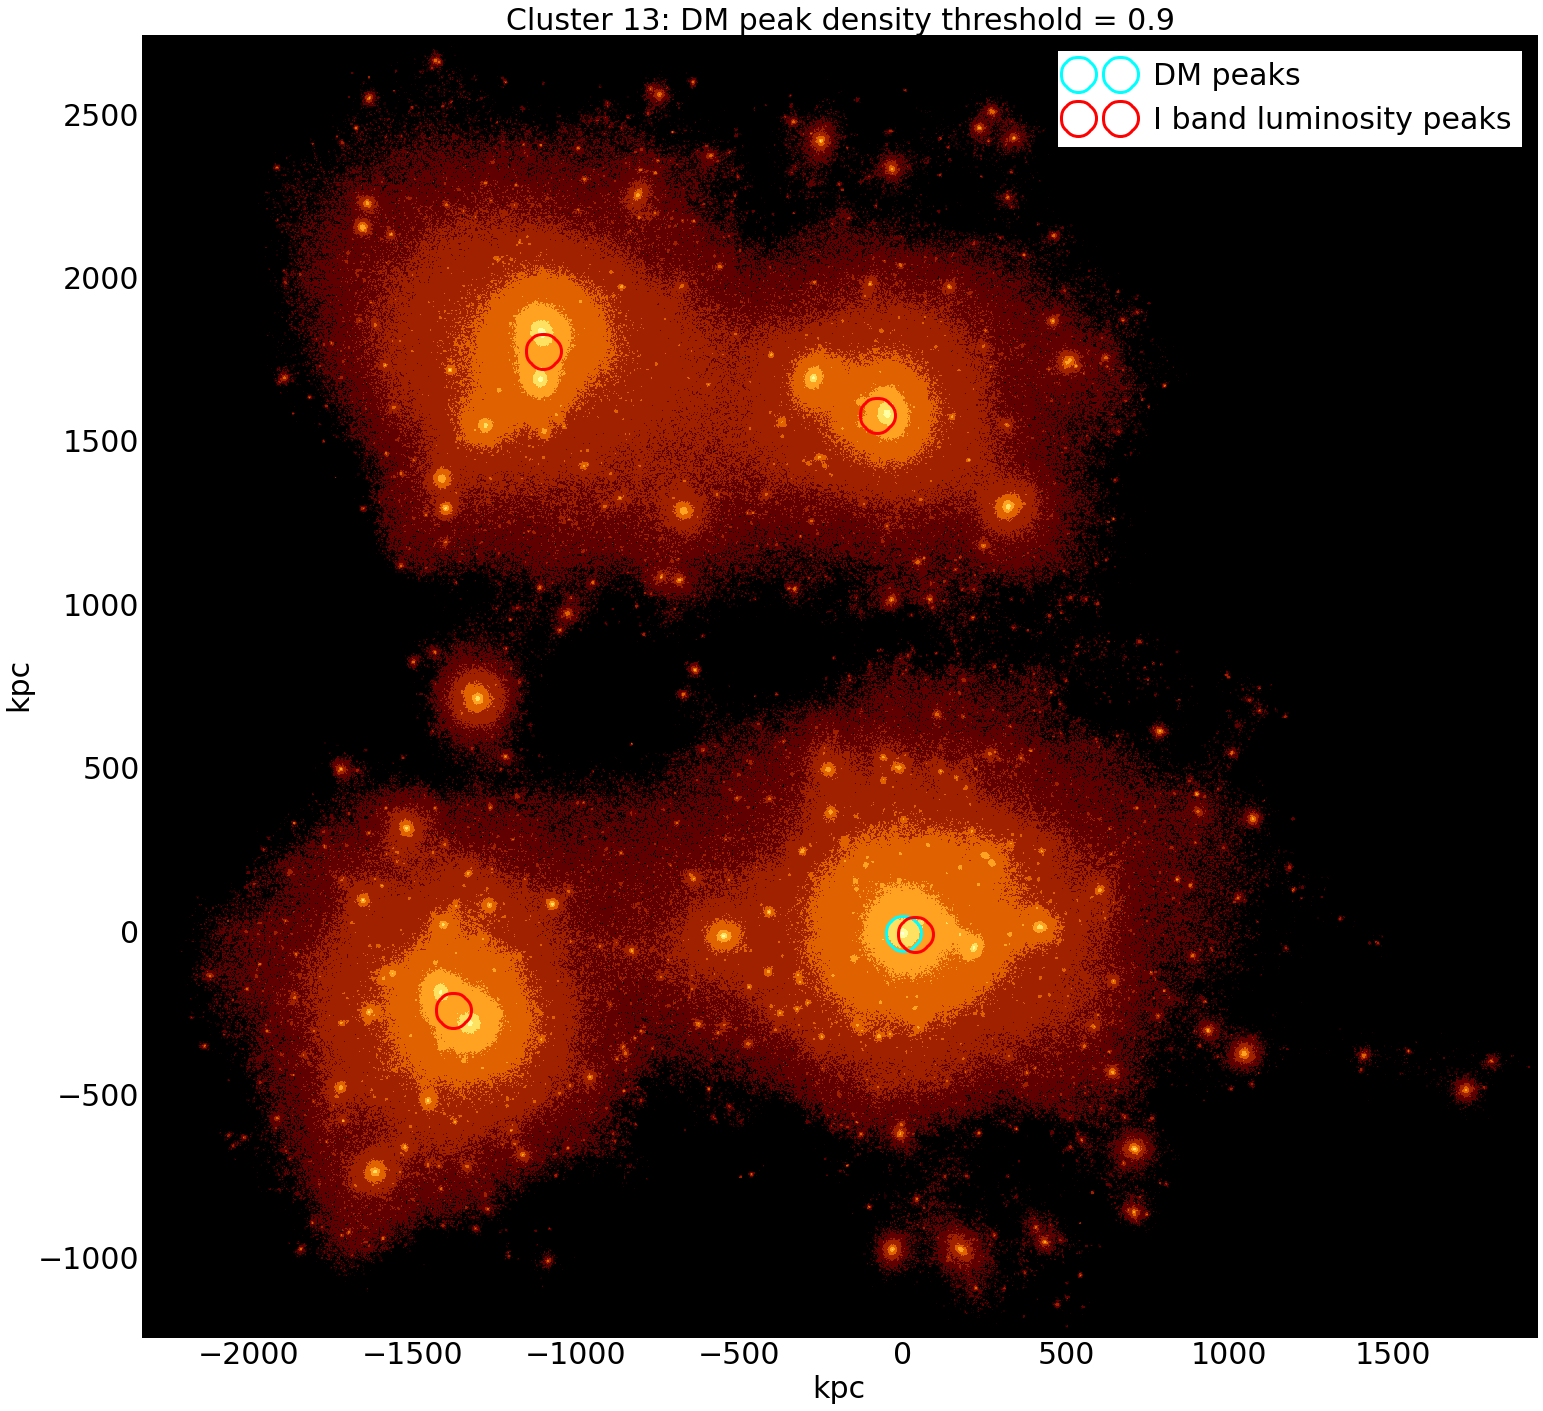

In [127]:
plt.figure(figsize=(25, 25))
%time plotDM.plot_DM_fhat(fhat, fhat_stars[clstNo], clstNo, threshold=threshold)

In [22]:
matches[clstNo] = {}

In [23]:
matches[clstNo]["dist"], matches[clstNo]["match_ix"] = \
    getDM.match_DM_peaks_with_gal_peaks(fhat, fhat_stars[clstNo], 
                                        threshold=threshold)

Converting subhalo distance units from kpc / h to kpc


In [24]:
uncertainty = np.sqrt(fhat_stars[clstNo]["bandwidth_matrix_H"])
err = np.sqrt(uncertainty[0, 0] ** 2. + uncertainty[1, 1])

In [25]:
print("offset = {0:.2f} +/- {1:.2f} kpc".format(
        matches[clstNo]["dist"][0], err + 2))

offset = 57.55 +/- 197.75 kpc


find offset from BCG

In [119]:
fhat["estimate"].

ERROR! Session/line number was not unique in database. History logging moved to new session 359


(2135, 1993)

In [117]:
_ = plt.hist(fhat["estimate"], bins=100)

KeyboardInterrupt: 

In [26]:
peaks_mask = fhat["peaks_dens"] > threshold

In [27]:
BCG_offsets = \
    np.sqrt(fhat["peaks_xcoords"][peaks_mask]**2 + 
            fhat["peaks_ycoords"][peaks_mask]**2)

In [28]:
np.sort(BCG_offsets)[:2]

array([   1.34095621,  221.09367371], dtype=float32)

In [29]:
galTree = getgal.get_gal_coords(clst_df)

In [30]:
peak_coords = np.array([fhat["peaks_xcoords"][peaks_mask],
                       fhat["peaks_ycoords"][peaks_mask]]).transpose()

In [31]:
len(peak_coords)

10

In [32]:
fhat.keys()

['peaks_colIx',
 'log_est',
 'peaks_rowIx',
 'peaks_ycoords',
 'peaks_dens',
 'estimate',
 'eval_points',
 'peaks_xcoords']

In [33]:
fhat["eval_points"][0] = \
    fhat["eval_points"][0].reshape(1, fhat["eval_points"][0].shape[0])

In [34]:
fhat["eval_points"][0].shape

(1, 2135)

In [35]:
fhat["eval_points"][1] = \
    fhat["eval_points"][1].reshape(1, fhat["eval_points"][1].shape[0])

In [36]:
fhat["eval_points"][1].shape

(1, 1993)

In [98]:
np.vstack(fhat["eval"])

array([-2329.69506836, -2327.69482422, -2325.69458008, ...,  2746.8972168 ,
        2748.89770508,  2750.89819336], dtype=float32)